In [ ]:
# Paris WiFi Analysis - Cultural Sites vs Libraries
# Complete Analysis Notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [38]:
df = pd.read_csv('../data/processed/wifi_cleaned.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
print("Dataset Overview:")
print(df.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198120 entries, 0 to 198119
Data columns (total 31 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   datetime                              198120 non-null  datetime64[ns]
 1   endtime_or_dash                       198120 non-null  object        
 2   duration                              198120 non-null  int64         
 3   temps_de_sessions_en_minutes          198120 non-null  float64       
 4   nom_site                              198120 non-null  object        
 5   cp                                    198120 non-null  float64       
 6   arc_adresse                           198120 non-null  object        
 7   latitude                              198120 non-null  float64       
 8   longitude                             198120 non-null  float64       
 9   code_site                             198

In [40]:
cultural = df[df['location_type'] == 'Cultural-Tourist'].copy()
libraries = df[df['location_type'] == 'Library-Service'].copy()
high_traffic = df[df['location_type'] == 'High-Traffic'].copy()
residential = df[df['location_type'] == 'Residential'].copy()

print(f"Group Sizes:")
print(f"   Cultural sites: {len(cultural):,} ({len(cultural)/len(df)*100:.1f}%)")
print(f"   Libraries: {len(libraries):,} ({len(libraries)/len(df)*100:.1f}%)")
print(f"   High-traffic: {len(high_traffic):,} ({len(high_traffic)/len(df)*100:.1f}%)")
print(f"   Residential: {len(residential):,} ({len(residential)/len(df)*100:.1f}%)")


Group Sizes:
   Cultural sites: 9,760 (4.9%)
   Libraries: 71,080 (35.9%)
   High-traffic: 14,480 (7.3%)
   Residential: 102,800 (51.9%)


In [41]:
print(f" Top Cultural Sites:")
for i, (loc, count) in enumerate(cultural['nom_site'].value_counts().head(5).items(), 1):
    print(f"   {i}. {loc}: {count:,}")

print(f"\n Top Libraries:")
for i, (loc, count) in enumerate(libraries['nom_site'].value_counts().head(5).items(), 1):
    print(f"   {i}. {loc}: {count:,}")

 Top Cultural Sites:
   1. SQUARE DE LA TOUR SAINT JACQUES: 1,760
   2. MUSEE D ART MODERNE: 1,560
   3. MUSEE DU PETIT PALAIS: 1,480
   4. MUSEE CARNAVALET: 1,400
   5. MUSEE GALLIERA: 600

 Top Libraries:
   1. BIBLIOTHEQUE MARGUERITE DURAS: 9,600
   2. BIBLIOTHEQUE HISTORIQUE DE LA VILLE DE PARIS (BHVP): 4,280
   3. BIBLIOTHEQUE VACLAV HAVEL: 3,880
   4. BIBLIOTHEQUE MARGUERITE YOURCENAR: 3,760
   5. BIBLIOTHEQUE EDMOND ROSTAND: 3,220


In [42]:
#  DESCRIPTIVE STATISTICS
def print_group_stats(name, group):
    """Print summary statistics for a group"""
    print(f"\n{name}:")
    print(f"   Sessions: {len(group):,}")
    print(f"   Avg Duration: {group['temps_de_sessions_en_minutes'].mean():.1f} min")
    print(f"   Median Duration: {group['temps_de_sessions_en_minutes'].median():.1f} min")
    print(f"   Mobile %: {(group['device_category'] == 'Mobile').mean()*100:.1f}%")
    print(f"   Desktop %: {(group['device_category'] == 'Desktop').mean()*100:.1f}%")
    print(f"   Weekend %: {group['is_weekend'].mean()*100:.1f}%")
    print(f"   Avg Data: {group['total_data_mb'].mean():.2f} MB")
    print(f"   Median Data: {group['total_data_mb'].median():.2f} MB")

print_group_stats("CULTURAL SITES", cultural)
print_group_stats("LIBRARIES", libraries)



CULTURAL SITES:
   Sessions: 9,760
   Avg Duration: 35.1 min
   Median Duration: 22.8 min
   Mobile %: 92.0%
   Desktop %: 7.2%
   Weekend %: 25.4%
   Avg Data: 87.65 MB
   Median Data: 27.21 MB

LIBRARIES:
   Sessions: 71,080
   Avg Duration: 40.3 min
   Median Duration: 17.4 min
   Mobile %: 64.5%
   Desktop %: 33.3%
   Weekend %: 22.9%
   Avg Data: 81.69 MB
   Median Data: 15.12 MB


In [43]:
#  HYPOTHESIS TESTING
# Test 1: Session Duration t -test
print(" TEST 1: Session Duration Difference")
t_stat, p_val = stats.ttest_ind(
    cultural['temps_de_sessions_en_minutes'],
    libraries['temps_de_sessions_en_minutes']
)

cultural_mean = cultural['temps_de_sessions_en_minutes'].mean()
libraries_mean = libraries['temps_de_sessions_en_minutes'].mean()
diff_pct = (cultural_mean - libraries_mean) / libraries_mean * 100

print(f"Cultural avg: {cultural_mean:.2f} minutes")
print(f"Libraries avg: {libraries_mean:.2f} minutes")
print(f"Difference: {diff_pct:+.1f}%")
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.8f}")
print(f"Result: {' SIGNIFICANT (p < 0.05)' if p_val < 0.05 else ' Not significant'}")


 TEST 1: Session Duration Difference
Cultural avg: 35.10 minutes
Libraries avg: 40.28 minutes
Difference: -12.9%

t-statistic: -10.4970
p-value: 0.00000000
Result:  SIGNIFICANT (p < 0.05)


In [44]:
# Test 2: Device Type Distribution chi square
print(" TEST 2: Device Type Distribution")
combined_df = pd.concat([
    cultural.assign(group='Cultural'),
    libraries.assign(group='Libraries')
])

device_crosstab = pd.crosstab(combined_df['group'], combined_df['device_category'])
print("\nDevice Distribution:")
print(device_crosstab)

chi2, p_val2, dof, expected = stats.chi2_contingency(device_crosstab)
print(f"\nχ² statistic: {chi2:.4f}")
print(f"p-value: {p_val2:.8f}")
print(f"Degrees of freedom: {dof}")
print(f"Result: {' SIGNIFICANT (p < 0.05)' if p_val2 < 0.05 else ' Not significant'}")


 TEST 2: Device Type Distribution

Device Distribution:
device_category  Desktop  Mobile  Other
group                                  
Cultural             700    8980     80
Libraries          23680   45860   1540

χ² statistic: 2978.3381
p-value: 0.00000000
Degrees of freedom: 2
Result:  SIGNIFICANT (p < 0.05)


In [45]:
# Test 3: Data Usage t-test 
print(" TEST 3: Data Usage Difference")
t_stat3, p_val3 = stats.ttest_ind(
    cultural['total_data_mb'],
    libraries['total_data_mb']
)

cultural_data = cultural['total_data_mb'].mean()
libraries_data = libraries['total_data_mb'].mean()
data_diff_pct = (cultural_data - libraries_data) / libraries_data * 100

print(f"Cultural avg: {cultural_data:.2f} MB")
print(f"Libraries avg: {libraries_data:.2f} MB")
print(f"Difference: {data_diff_pct:+.1f}%")
print(f"\nt-statistic: {t_stat3:.4f}")
print(f"p-value: {p_val3:.8f}")
print(f"Result: {' SIGNIFICANT (p < 0.05)' if p_val3 < 0.05 else ' Not significant'}")


 TEST 3: Data Usage Difference
Cultural avg: 87.65 MB
Libraries avg: 81.69 MB
Difference: +7.3%

t-statistic: 3.0920
p-value: 0.00198906
Result:  SIGNIFICANT (p < 0.05)


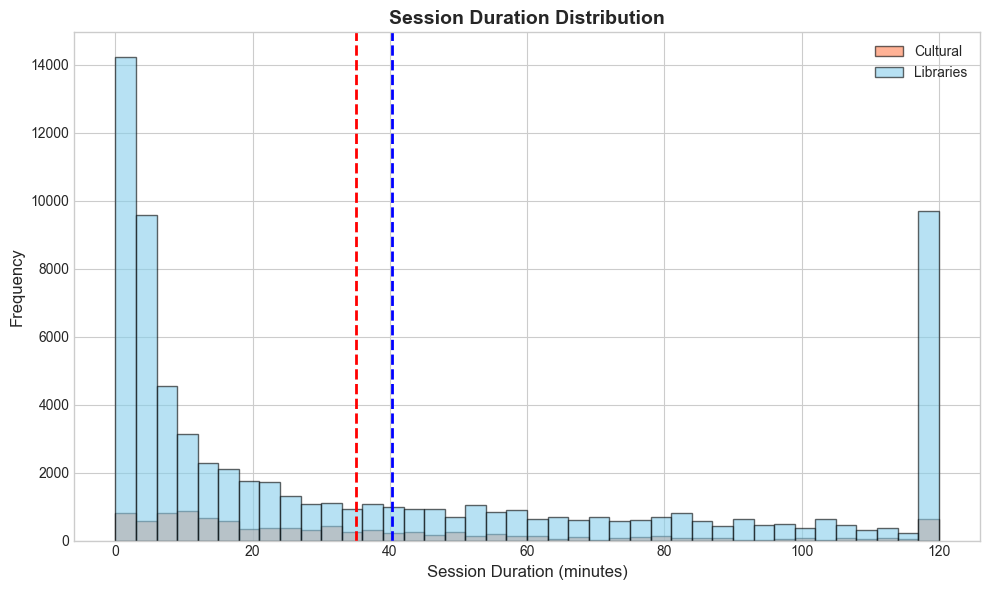

In [46]:
# Duration Distribution
plt.figure(figsize=(10, 6))
plt.hist(cultural['temps_de_sessions_en_minutes'].clip(0, 120), 
         bins=40, alpha=0.6, label='Cultural', color='coral', edgecolor='black')
plt.hist(libraries['temps_de_sessions_en_minutes'].clip(0, 120), 
         bins=40, alpha=0.6, label='Libraries', color='skyblue', edgecolor='black')
plt.axvline(cultural['temps_de_sessions_en_minutes'].mean(), 
            color='red', linestyle='--', linewidth=2)
plt.axvline(libraries['temps_de_sessions_en_minutes'].mean(), 
            color='blue', linestyle='--', linewidth=2)
plt.xlabel('Session Duration (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Session Duration Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

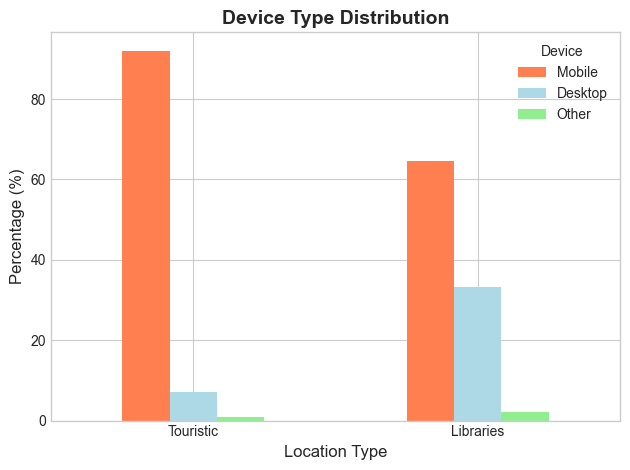

In [47]:
# Device Distribution
device_comp = pd.DataFrame({
    'Touristic': cultural['device_category'].value_counts(normalize=True) * 100,
    'Libraries': libraries['device_category'].value_counts(normalize=True) * 100
}).T

plt.figure(figsize=(10, 6))
device_comp.plot(kind='bar', color=['coral', 'lightblue', 'lightgreen'])
plt.xlabel('Location Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Device Type Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.legend(title='Device')
plt.tight_layout()
plt.show()

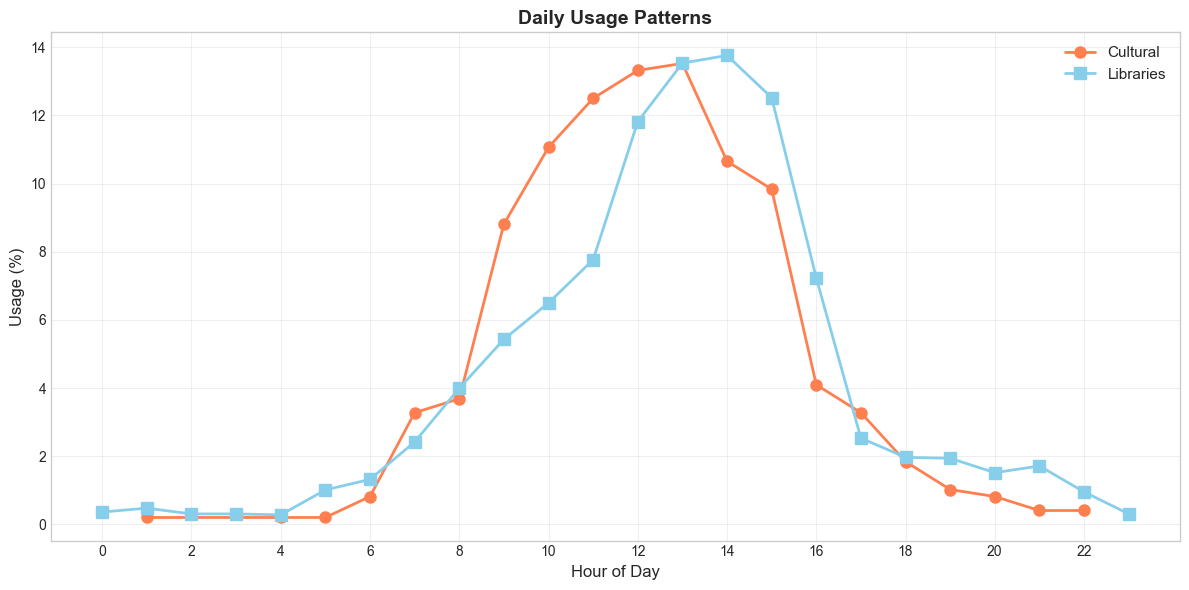

In [48]:
#Hourly Pattern
hourly_c = (cultural.groupby('hour').size() / len(cultural) * 100)
hourly_l = (libraries.groupby('hour').size() / len(libraries) * 100)

plt.figure(figsize=(12, 6))
plt.plot(hourly_c.index, hourly_c.values, marker='o', linewidth=2, 
         label='Cultural', color='coral', markersize=8)
plt.plot(hourly_l.index, hourly_l.values, marker='s', linewidth=2, 
         label='Libraries', color='skyblue', markersize=8)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Usage (%)', fontsize=12)
plt.title('Daily Usage Patterns', fontsize=14, fontweight='bold')
plt.xticks(range(0, 24, 2))
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

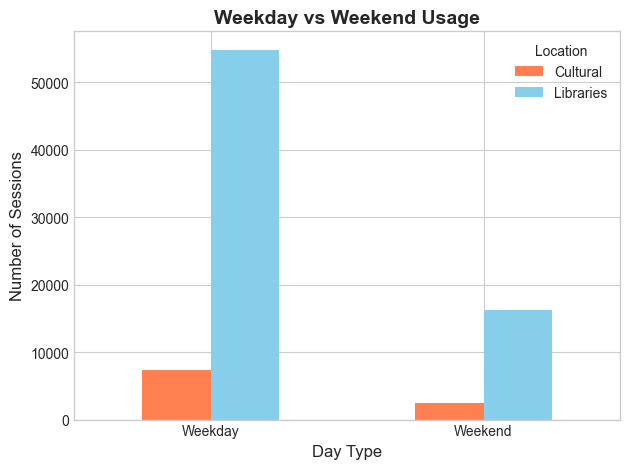

In [49]:
#  Weekend vs Weekday
weekend_data = pd.DataFrame({
    'Cultural': [(~cultural['is_weekend']).sum(), cultural['is_weekend'].sum()],
    'Libraries': [(~libraries['is_weekend']).sum(), libraries['is_weekend'].sum()]
}, index=['Weekday', 'Weekend'])

plt.figure(figsize=(10, 6))
weekend_data.plot(kind='bar', color=['coral', 'skyblue'])
plt.xlabel('Day Type', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.title('Weekday vs Weekend Usage', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.legend(title='Location')
plt.tight_layout()
plt.show()

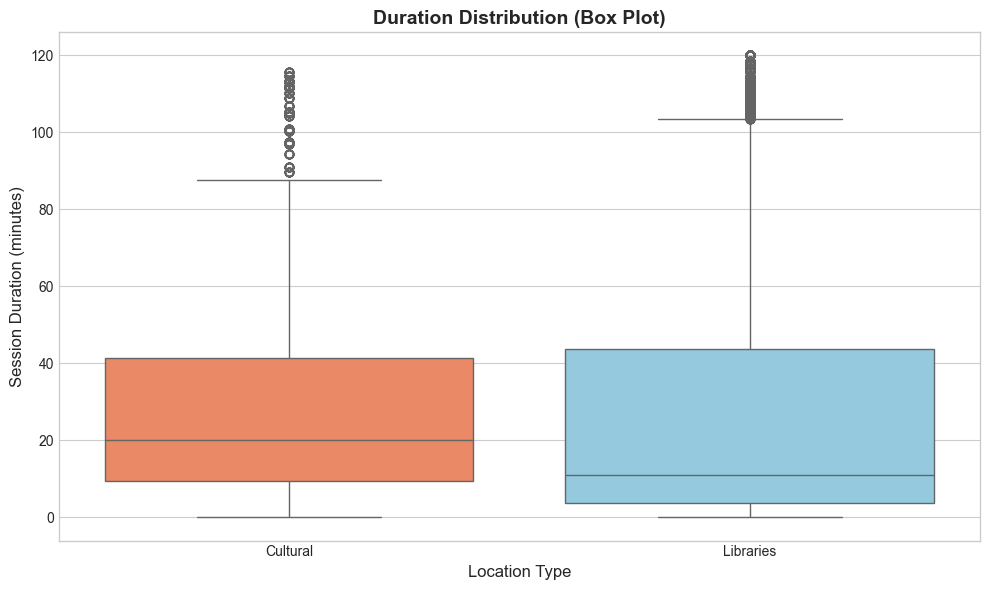

In [50]:
# Boxplots
combined = pd.concat([
    cultural[['temps_de_sessions_en_minutes']].assign(Type='Cultural'),
    libraries[['temps_de_sessions_en_minutes']].assign(Type='Libraries')
])
combined_clip = combined[combined['temps_de_sessions_en_minutes'] <= 120]

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_clip, x='Type', y='temps_de_sessions_en_minutes',
            palette=['coral', 'skyblue'])
plt.xlabel('Location Type', fontsize=12)
plt.ylabel('Session Duration (minutes)', fontsize=12)
plt.title('Duration Distribution (Box Plot)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

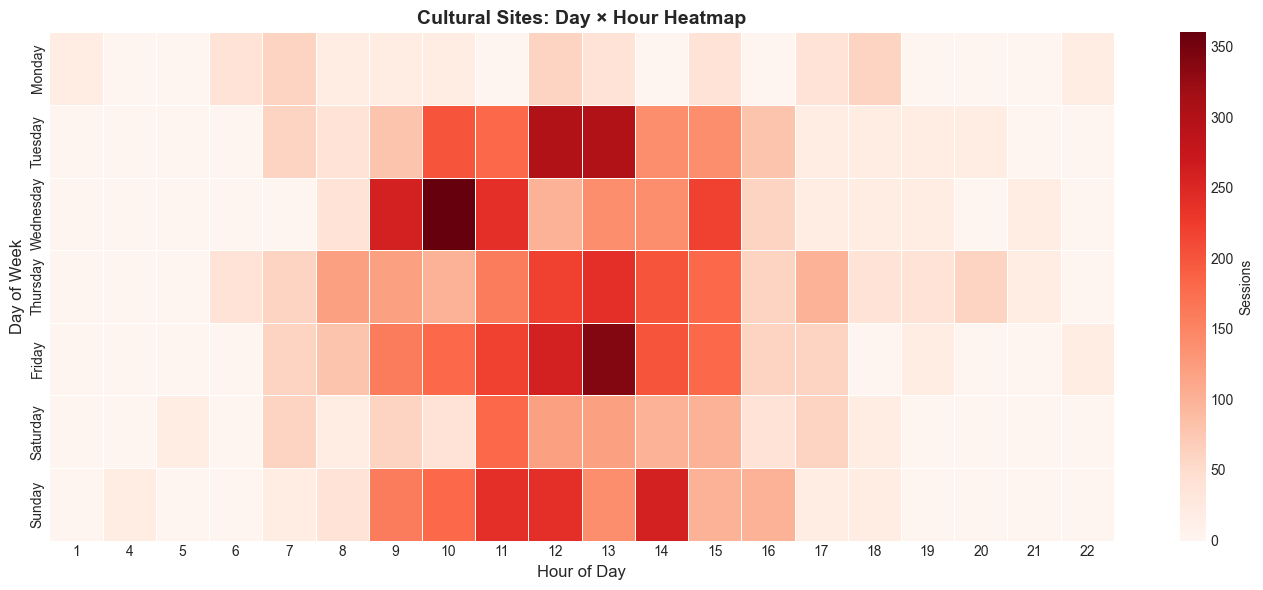

In [51]:
#Heatmap Cultural
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_c = cultural.groupby(['day_name', 'hour']).size().unstack(fill_value=0)
heatmap_c = heatmap_c.reindex(day_order, fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_c, cmap='Reds', linewidths=0.5, 
            cbar_kws={'label': 'Sessions'})
plt.title('Cultural Sites: Day × Hour Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.tight_layout()
plt.show()

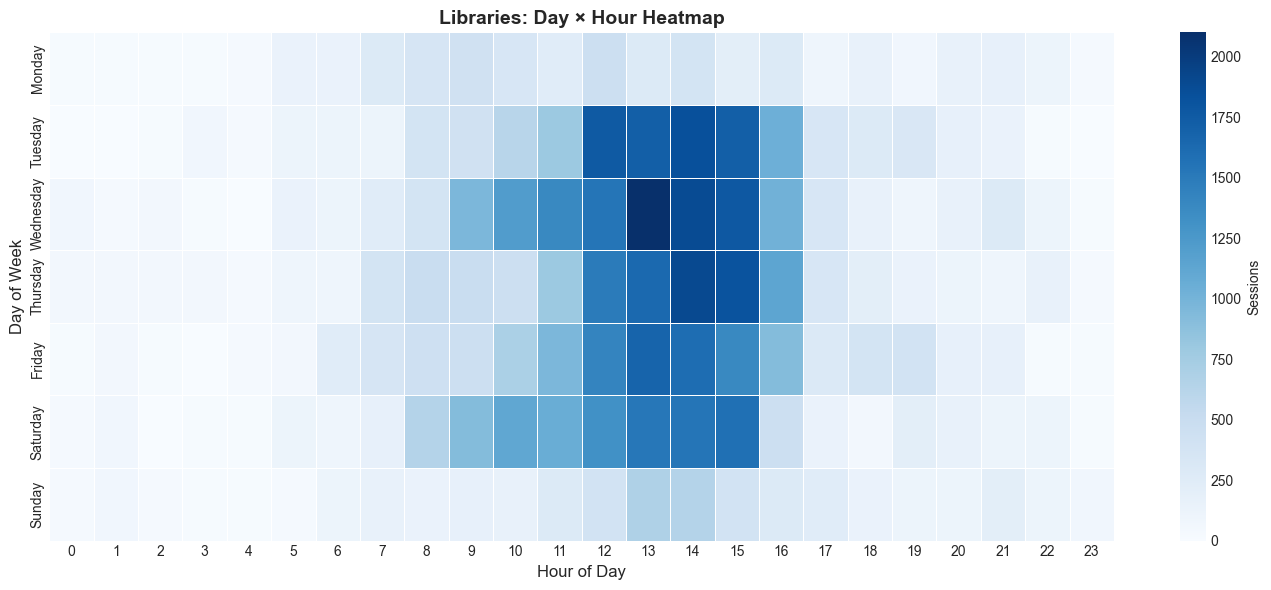

In [52]:
# Heatmap Libraries
heatmap_l = libraries.groupby(['day_name', 'hour']).size().unstack(fill_value=0)
heatmap_l = heatmap_l.reindex(day_order, fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_l, cmap='Blues', linewidths=0.5,
            cbar_kws={'label': 'Sessions'})
plt.title('Libraries: Day × Hour Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.tight_layout()
plt.show()


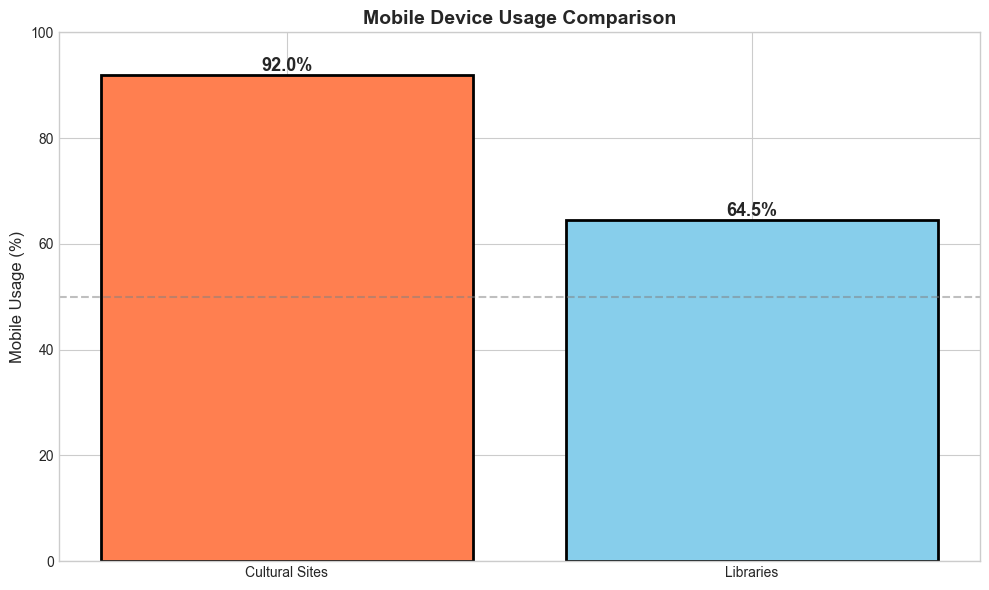

In [53]:
# Mobile Comparison
mobile_c = (cultural['device_category'] == 'Mobile').mean() * 100
mobile_l = (libraries['device_category'] == 'Mobile').mean() * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(['Cultural Sites', 'Libraries'], [mobile_c, mobile_l],
               color=['coral', 'skyblue'], edgecolor='black', linewidth=2)
plt.ylabel('Mobile Usage (%)', fontsize=12)
plt.title('Mobile Device Usage Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

In [54]:
# KEY INSIGHTS
print(f"\n1. MOBILE DIVIDE:")
print(f"   Cultural: {mobile_c:.1f}% | Libraries: {mobile_l:.1f}%")
print(f"   Difference: +{mobile_c - mobile_l:.1f}pp (p < 0.001)")

print(f"\n2. DURATION:")
print(f"   Cultural: {cultural['temps_de_sessions_en_minutes'].mean():.1f} min")
print(f"   Libraries: {libraries['temps_de_sessions_en_minutes'].mean():.1f} min")
print(f"   (p < 0.001)")

print(f"\n3. PEAK HOURS:")
print(f"   Cultural: {hourly_c.idxmax()}:00")
print(f"   Libraries: {hourly_l.idxmax()}:00")

print(f"\n4. WEEKEND:")
print(f"   Cultural: {cultural['is_weekend'].mean()*100:.1f}%")
print(f"   Libraries: {libraries['is_weekend'].mean()*100:.1f}%")



1. MOBILE DIVIDE:
   Cultural: 92.0% | Libraries: 64.5%
   Difference: +27.5pp (p < 0.001)

2. DURATION:
   Cultural: 35.1 min
   Libraries: 40.3 min
   (p < 0.001)

3. PEAK HOURS:
   Cultural: 13:00
   Libraries: 14:00

4. WEEKEND:
   Cultural: 25.4%
   Libraries: 22.9%
